## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [181]:
!pip3 install imblearn
!pip3 install xgboost

In [182]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import ADASYN, SMOTE

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
df_train = pd.read_csv('./training.csv')
df_train.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [183]:
df_train.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [184]:
df_train.isnull().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

### Check invariant metric
Check number of observations in control and treatment group to see if the groups are balanced and there is no statistically significant difference. The null hypothesis is that the groups are equal, and we must perform a two-tailed test.

In [185]:
n_obs = df_train.shape[0]
n_control = df_train[df_train['Promotion'] == 'No'].shape[0]

p = 0.5
sd = np.sqrt(p * (1-p) * n_obs)

z = ((n_control + 0.5) - p * n_obs) / sd

print('z-score: ', z)
print('p-value: ', 2 * sp.stats.norm.cdf(z))

z-score:  -0.6638066506192843
p-value:  0.5068140685419046


The p-value shows that the difference between groups is not statistically significant and that we must fail to reject the null hypothesis.

### Icremental Response Rate (IRR)

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

In [186]:
df_train.groupby('Promotion').sum()['purchase']

Promotion
No     319
Yes    721
Name: purchase, dtype: int64

In [187]:
#Calculate IRR
n_control = df_train[df_train['Promotion'] == 'No'].shape[0]
n_treat = df_train[df_train['Promotion'] == 'Yes'].shape[0]
purch_control = df_train.query('Promotion == "No" and purchase == 1').shape[0]
purch_treat = df_train.query('Promotion == "Yes" and purchase == 1').shape[0]

IRR = purch_treat/n_treat - purch_control/n_control
print('Incremental response rate (IRR): ', IRR)

Incremental response rate (IRR):  0.009454547819772702


An IRR of about 0.0095 indicates that the promotion results in additional purchases in the treatment group. The following hypothesis test will determine if the increase in purchase rate is statistically significant.

The null hypothesis is that the IRR is less than or equal to 0, meaning that the promotion does not lead to increased sales. The alternative hypothesis is that the IRR is greater than 0.

$$H_0: {IRR \leq 0}$$
$$H_1: {IRR > 0}$$

Because we have two evaluation metrics, we have to use a correction to avoid making a type I error. Using the Bonferroni correction (dividing the alpha with number of evaluation metrics) gives us an alpha of 0.025

$$\alpha = 0.025$$

In [188]:
#Calculate proportion who made a purchase in each group and a pooled proportion
prop_control = purch_control / n_control
prop_treat = purch_treat / n_treat
prop_total = (purch_control + purch_treat) / (n_control + n_treat)

#Compute standard error
se_prop = np.sqrt(prop_total * (1-prop_total) * (1/n_control + 1/n_treat))

#Compute z-score
z = (prop_treat - prop_control) / se_prop

print('z-score: ', z)
print('p-value: ', 1 - sp.stats.norm.cdf(z))

z-score:  12.468449461599388
p-value:  0.0


The p-value of 0 tells us that there is definitely a statistically significant increase in purchase rate from the promotion, and we must therefore reject the null hypothesis.

### Net Incremental Revenue (NIR)

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

In [189]:
#Calculate NIR
NIR = (10 * purch_treat - 0.15 * n_treat) - 10 * purch_control
print('Net incremental revenue: ', NIR)

Net incremental revenue:  -2334.5999999999995


The NIR of -2334.6 indicates that Starbucks' cost of distributing the promotion exceeds the profits gained from the promotion. We will perform a hypothesis test to see if this observed NIR is statistically significant.

The null hypothesis is that the NIR is smaller than or equal to 0, meaning that the promotion does not result in a net increase in revenue. The alternative hypothesis is that the NIR is greater than 0.

$$H_0: {NIR \leq 0}$$
$$H_1: {NIR > 0}$$

As the Bonferroni correction has been applied, the significance level is at 0.025

$$\alpha = 0.025$$

In [190]:
#Use bootstrapping to simulate a distribution under the null hypothesis
NIR_test = []

for _ in range(10000):
    boot_sample = df_train.sample(20000, replace=True)
    sample_purch_control = boot_sample.query('Promotion == "No" and purchase == 1').shape[0]
    sample_purch_treat = boot_sample.query('Promotion == "Yes" and purchase == 1').shape[0]
    sample_n_treat = boot_sample.query('Promotion == "Yes"').shape[0]
    NIR_test.append((10 * sample_purch_treat - 0.15 * sample_n_treat) - 10 * sample_purch_control)

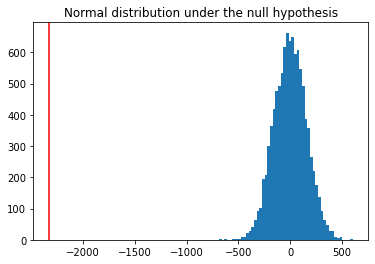

In [191]:
#Simulate and plot a normal distribution under the null hypothesis
null_distribution = np.random.normal(0, np.std(NIR_test), 10000)
plt.hist(null_distribution, bins=50)
plt.axvline(NIR, c='red')
plt.title('Normal distribution under the null hypothesis');

In [192]:
#Compute p-value
pval = (NIR<null_distribution).mean()
print('p-value: ', pval)

p-value:  1.0


The observed NIR value falls far below the normal distribution under the null hypothesis, and the p-value of 1 tells us that we must fail to reject the null hypothesis. This leads to the conclusion that sending the promotion to every customer will lead to a net loss for Starbucks.

### Maximize IRR and NIR using modelling
The next step is to create a model to maximize the two evaluation metrics. Using a machine learning classification algorithm we can predict which customers are the most likely to make a purchase upon receiving the promotion, and use this information to execute targeted promotion.

As the data is quite unbalanced, with a very low proportion of customers making a purchase, I want to use an upsampling technique to balance out the data. I will use SMOTE (Synthetic Minority Oversampling Technique), which oversamples the minority class to create a balanced dataset for training.

In [193]:
#Generate a column with 1 if the customer received promotion and made purchase, and 0 for all others
df_train['response'] = df_train.apply(lambda row: 1 if (row['purchase'] == 1) and (row['Promotion'] == "Yes") else 0, axis=1, result_type='expand')

In [194]:
df_train.response.value_counts()

0    83813
1      721
Name: response, dtype: int64

In [195]:
#Create X and y to split into training and test data
X = df_train.drop(['ID', 'Promotion', 'purchase', 'response'], axis=1)
y = df_train.response

In [196]:
#Split the dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [197]:
#Use upsampling to generate synthetic data 
X_train_upsample, y_train_upsample = SMOTE(random_state=42).fit_resample(X_train, y_train)

In [198]:
#Build a classification model using Random Forest Classifier
model_rfc = sk.ensemble.RandomForestClassifier(max_depth=10, random_state=42, n_estimators=1000)
model_rfc.fit(X_train_upsample, y_train_upsample)

RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=42)

In [199]:
#Make prediction on test set
y_preds = clf.predict(X_test)

In [200]:
print("=====Confusion matrix=====\n", confusion_matrix(y_test, y_preds))
cv_score = cross_val_score(clf, X_train_upsample, y_train_upsample, cv=3, scoring='roc_auc')
print("=====Cross Validation Score (AUC)=====\n", cv_score.mean())

=====Confusion matrix=====
 [[11927  4839]
 [   83    58]]
=====Cross Validation Score (AUC)=====
 0.872540697425977


In [201]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''    
    y_pred = model_rfc.predict(df)
    
    promotion_yes_no = []
    for pred in y_pred:
        if pred == 0:
            promotion_yes_no.append("No")
        if pred == 1:
            promotion_yes_no.append("Yes")
    
    promotion = np.asarray(promotion_yes_no)
    
    return promotion

In [202]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0175.

Your nir with this strategy is 144.35.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.017511709918127026, 144.35000000000002)

The model using Random Forest classifier performed slightly worse than the benchmark. It's still a positive net result for Starbucks using targetet promotions based on this model, but I'd like to improve the model to increase the evaluation metrics.

I want to try to use an XGBoost classifier.

In [203]:
#Build and train a model using xgboost
eval_set = [(X_train_upsample, y_train_upsample), (X_test, y_test)]
model_xgb = xgb.XGBClassifier(learning_rate = 0.175,
                          max_depth = 7,
                          min_child_weight = 5,
                          objective = 'binary:logistic',
                          seed = 42,
                          gamma = 0.3,
                          use_label_encoder=False,
                          silent = True)
model_xgb.fit(X_train_upsample, y_train_upsample, eval_set=eval_set, eval_metric='auc', verbose=True, early_stopping_rounds=30)

[13:31:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.74629	validation_1-auc:0.56087
[1]	validation_0-auc:0.77672	validation_1-auc:0.56292
[2]	validation_0-auc:0.79425	validation_1-auc:0.55668
[3]	validation_0-auc:0.79989	validation_1-auc:0.56249
[4]	validation_0-auc:0.82484	validation_1-auc:0.57844
[5]	validation_0-auc:0.83684	validation_1-auc:0.57690
[6]	validation_0-auc:0.85561	validation_1-auc:0.57172
[7]	validation_0-auc:0.86349	validation_1-auc:0.58159
[8]	validation_0-auc:0.87377	validation_1-auc:0.57987
[9]	validation_0-auc:0.87895	validation_1-auc:0.57656
[10]	validation_0-auc:0.88772	validation_1-auc:0.57869
[11]	validation_0-auc:0.88765	validation_1-auc:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.175, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [204]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''    
    y_pred = model_xgb.predict(df)
    
    promotion_yes_no = []
    for pred in y_pred:
        if pred == 0:
            promotion_yes_no.append("No")
        if pred == 1:
            promotion_yes_no.append("Yes")
    
    promotion = np.asarray(promotion_yes_no)
    
    return promotion

In [205]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0214.

Your nir with this strategy is 313.25.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.021353518813767878, 313.25)

This model performed much better. We now have an Incremental Response Rate (IRR) of 0.0214 and a Net Incremental Revenue of 313.25, which means both our evaluation metrics have outperformed the benchmark of 0.0188 and 189.45, respectively.

Using this machine learning model, Starbucks would be able to perform targeted promotions to the customers who are likely to purchase the promoted product, instead of blindly distributing promotions to all customers, which would likely lead to a net loss.